\maketitle



## Overview



ESBMTK provides a couple of classes which are used to define a
model. The classes are arranged in a hierarchical manner, starting
with the model class. The model class (or object), set's global
parameters like the model name, the time step etc. Next comes one or
more element objects which define basic element properties. Each
element can have one or more species. Note that these classes specify
units, however at present, there is incomplete support for unit
conversions. So it is up to the author to ensure proper unit
conversions. It is therefore best, to use the same units throughout.



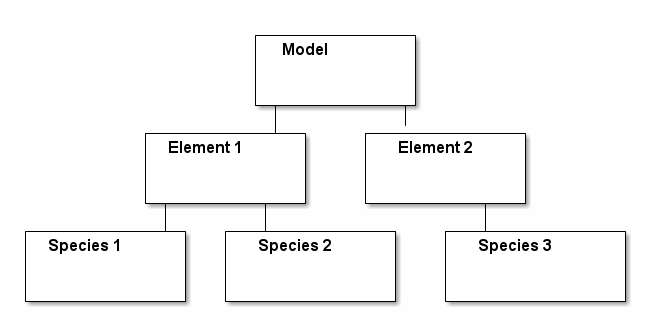

In [1]:
+---------------+ 
                       |  Model        | 
                       |               | 
                       |               | 
                       |               | 
                       +-+------------++
                    	 |            |
            +------------+--+	  +---------------+
            | Element 1     |	  |  Element 2    |
            |               |	  |               |
            |               |	  |               |
            |               |	  |               |
            +-+--+------+---+  	  +-----------+---+
              |    	|		      |
+----+--------+-+   +---+------------+    +---+-------------+
| Species 1     |   |  Species 2     |    |  Species 3      |
|               |   | 	 	     |    |                 |
|               |   | 	 	     |    |                 |
|               |   |                |    |                 |
+---------------+   +----------------+    +-----------------+

At present, these classes only specify the isotopic reference ratios,
and plot labels.

Next comes the source and sink class, which simply specify the name
and species, followed by reservoir object which specifies things like
reservoir name, reservoir size, reservoir species etc.  Each reservoir
can only have one element. This is counter intuitive since we would
think of the ocean as single reservoir with many elements. However,
the model only attempts to track the transfer of mass between
reservoirs, for a given element. For multi element models, you need to
setup reservoirs and connections for each element.

Sources, sinks, and reservoirs are connected through fluxes, and
fluxes are either forced by signals, or affected by processes. Most
processes can be derived implicitly from the way we connect reservoirs
(see below), however signal must be specified explicitly. It is thus
best to define these first (see the worked example below).

The connection between a source and a sink (or two reservoirs) is
handled by the connection class. This class will create the necessary
fluxes, and where possible add processes. Fluxes and processes are
also implemented as objects.



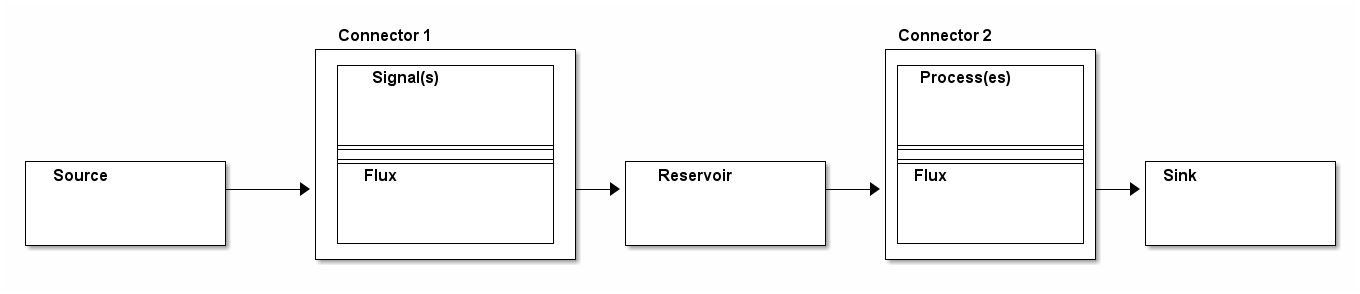

In [1]:
Connector 1                                             Connector 2
			     +-------------------------+			      +--------------------+
			     | +---------------------+ |			      |+------------------+|
			     | |  Signal(s)          | |			      || Process(es)      ||
			     | |                     | |			      ||                  ||
			     | |                     | |			      ||                  ||
			     | |                     | |			      ||                  ||
			     | |                     | |			      ||                  ||
			     | +---------------------+ |			      |+------------------+|
+-------------------+  	     | +---------------------+ |    +-------------------+     |+------------------+|	+------------------+
|  Source     	    |	     | |  Flux               | |    |  Reservoir        |     || Flux             ||	| Sink             |
|             	    +------->| |                     | +--->+         	        +---->||                  |+--->+                  |
|             	    |	     | |                     | |    |         	        |     ||                  ||	|                  |
|             	    |	     | |                     | |    |         	        |     ||                  ||	|                  |
|                   |	     | |                     | |    |         	        |     ||                  ||	|                  |
+-------------------+	     | +---------------------+ |    +-------------------+     |+------------------+|	+------------------+
			     +-------------------------+			      +--------------------+

Each connector object can have more than one signal or process (or a
mixture of signals and processes). Each reservoir can have more than
one connector object.



### A worked example



In the following example we will set up a simple carbon cycle
model. The data forcing the anthropogenic carbon flux will be read
from a csv file. Interaction with external data is handled through the
external data object which allows to integrate external data into the
model framework. It can then be used to generate a signal, or it can
be associated with a reservoir so that the data is plotted with the
reservoir data.

The model consists of four sources, two sinks, and one reservoir



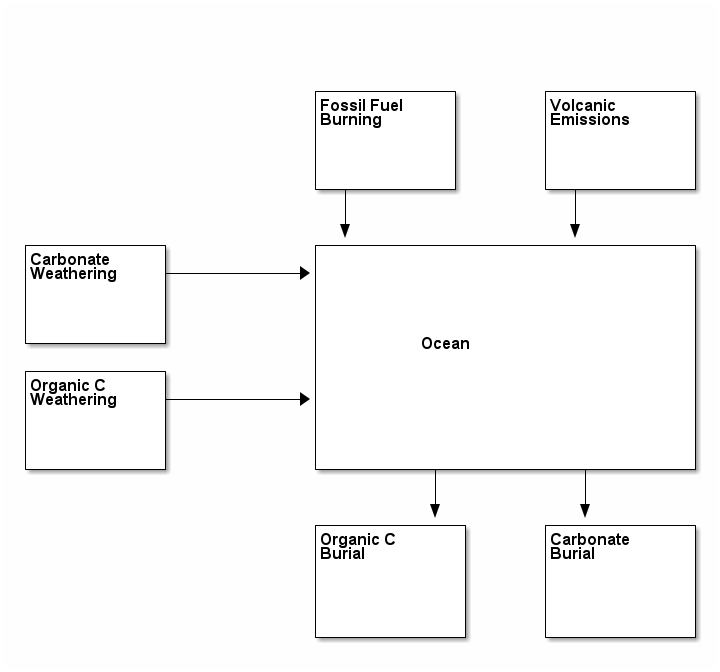

In [1]:
+-------------+        +--------------+
			     |Fossil Fuel  |        |Volcanic      |
			     |Burning      |        |Emissions     |
			     |             |        |              |
			     |             |        |              |
			     |             |        |              |
			     |             |        |              |
			     +--+----------+        +--+-----------+
				|		       |
				|		       |
				v		       v
+-------------+		     +--+----------------------+-----------+
|Carbonate    |		     |        	                           |
|Weathering   +------------->|        	                           |
|             |	             |        	                           |
|             |		     |        	                           |
|             |		     |        	                           |
|             |		     |        	                           |
+-------------+		     |        	Ocean                      |
			     |        	                           |
+-------------+		     |        	                           |
|Organic C    |		     |        	                           |
|Weathering   +------------->+        	                           |
|             |		     |        	                           |
|             |		     |        	                           |
|             |		     |        	                           |
|             |		     |        	                           |
+-------------+		     +-----------+--------------+----------+
					 |		|
					 |		|
					 v		v
			     +-----------+--+	    +---+----------+
			     |Organic C     | 	    |Carbonate     |
			     |Burial        |  	    |Burial        |
			     |              | 	    |              |
			     |              | 	    |              |
			     |              | 	    |              |
			     |              |	    |              |
			     |              |	    |              |
			     +--------------+ 	    +--------------+

### Setting up the model



We need to load all required libraries and all classes we want to
use. Interaction with the model classes is done through keyword/value
pairs. Use `help()` to inquire about the supported keyword value
pairs.

ESBMTK is unit aware. The units are used to map all input data to
internal units. The type of internal units needs to specified when
creating the model object. The time unit is derived from the timestep
variable. I.e., if the timestep is given in seconds, all other time
related input will be mapped to seconds. Similarly you have to define
the base mass unit. Typically, this will be moles, but other units
like grams etc can also be used.  At present ESBMTK cannot convert
between different types of mass units (e.g., kg to moles).  The usual
prefixes like kilo, mega, milli etc are recognized. Volume units like
`l` or `m**3` are recognized as well. ESBMTK also defines the sverdrup
("Sv")

Once the input units are mapped to base units specified by the model
object, all data will be reported in the base units. The only
exception is the `object.plot()` method which will transform the data
back into the original unit. In other words, if your timestep is in
years, but you specify your endtime in kyrs, the time axis will be
plotted in kyrs. Similarly for all other data, with the exception of
the isotope delta values.

    from esbmtk import Model, Element, Species, Reservoir
    from esbmtk import Signal, Connect, Source, Sink, Flux
    from esbmtk import ExternalData
    
    # create model
    Model(
        name="C_Cycle",     # model name
        stop="200 yrs",     # end time of model
        timestep=" 1 yr",   # time unit
        mass_unit = "mol",  # mass unit
        volume_unit = "l",  # volume unit
    )



### Declare elements and species



We register the elements(s) with the model by providing the model
name. Note that this is not a string, but the model handle which is
derived from the model name in the model definition above. We use the
element handle in a similar way to register the species with an
element.

    # Element properties
    Element(
        name="C",                  # Element Name
        model=C_Cycle,             # Model handle
        mass_unit="mmol",          # base mass unit
        li_label="C^{12$S",        # Name of light isotope
        hi_label="C^{13}$S",       # Name of heavy isotope
        d_label="$\delta^{13}$C",       # Name of isotope delta
        d_scale="VPDB",            # Isotope scale. End of plot labels
        r=0.0112372,  # VPDB C13/C12 ratio https://www-pub.iaea.org/MTCD/publications/PDF/te_825_prn.pdf
    )
    
    # add species
    Species(name="CO2", element=C)  # Name & element handle
    Species(name="DIC", element=C)
    Species(name="OM", element=C)
    Species(name="CaCO3", element=C)

You can do this explicitly as in the example above, or use the builtin
definition by providing the element keyword in the model
definition. This keyword takes and element name, and causes the model
to initialize an `Element` object and a variety of `Species`
objects. At present ESBMT contains definitions for "Carbon" and
"Sulfur" which will create the element objects `C` and `S`
respectively. You can query which species are known to an element by
calling the `list_species` method, e.g., `C.list_species()`

You can initialize more than one element by providing a list as
argument (i.e., `["Sulfur", "Carbon"]). In other words, you can
replace the above code block by adding =element = "Carbon"` to the
model parameters.



### Using external data to initialize a signal



We can use an external csv file to create a signal. The first column
contains the time coordinates, the second the flux rate, and the third
the delta value of the flux.  The first row must contain a header, and
the header must contain a variable name followed by a unit:

| Age [kyr]|Volcanic Flux [mol/s]|&delta;<sup>13</sup>C [permille]|
|---|---|---|
| 0|20|0|
| 1|30|2|

Note that the unit must be specified inside square brackets. All
values will be mapped into the model units and interpolated to fit the
model time resolution.

Signals can also by created by specifying a signal type. At
present the class understands, square, and pyramidal signal forms, as
well as repetition. Signal can be added to each other (i.e., you can
specify a signal which effects the flux, and then add another signal
which effects the isotope ratio).

    Signal(name = "ACR",              # Signal name
           species = CO2,             # Species
           filename = "test-data.csv" # filename
    )

Once a signal instance has been created, it can be passed to a
connector object in order to associate it with a flux (see the first
connection below as an example).



### Sources, Sinks and Reservoirs



The fundamental model object is the reservoir. Reservoirs are
connected to each other by one or more fluxes. Fluxes are created
implicitly by connecting two reservoirs. 

Connecting a reservoir with a Source or Sink also creates a flux, but
unlike reservoirs, sources and sinks do not have any associated
data. They are merely there to allow the creation of a flux.

    Source(name="Fossil_Fuel_Burning", species=CO2)
    Source(name="Carbonate_Weathering", species=CO2)
    Source(name="Organic_Weathering", species=CO2)
    Source(name="Volcanic", species=CO2)
    Sink(name="Carbonate_burial", species=CaCO3)
    Sink(name="OM_burial", species=OM)
    
    Reservoir(
        name="Ocean",                # Name of reservoir
        species=DIC,                 # Species handle
        delta=2,                     # initial delta
        concentration="2.62 mmol/l", # cocentration 
        volume="1.332E18 m**3",      # reservoir size (m^3)
    )



### Connecting sources, reservoirs and sinks



Now that all model elements are specified, we can connect
everything. The first statement below, connects the source
`Fossil_Fuel_Burning` with the reservoir `Ocean`. This will create a
flux with the name `Fossil_Fuel_Burning_to_Ocean`. The rate and delta
keywords indicate that this flux will be zero. However, we provide `pl
= [ACR]` which is the carbon flux data which we imported via the
signal object above. This data will be added to the
`Fossil_Fuel_Burning_to_Ocean` flux (since the process is additive,
the initial flux has to be zero!)

The type of flux depends on how we specify the connection. In the
previous example we provided a signal, so the flux will change with
time according to the signal data. If you look at the connection
between `Carbonate_Weathering` and `Ocean` below, we specify a given
rate and delta value. So this flux will not change over time. If you
look at the connection between `Ocean` and `OM_burial` the connection
specifies a constant flux but with an `alpha = -26.3`. This indicates
that this flux involves a fixed isotope offset relative to the
upstream reservoir, i.e., the isotope ratio of this flux will change
dynamically in response to the isotope ratio of the reservoir, but
with a constant offset. See below for a full list of connection
options.

Fluxes can be circular, care must however be taken in which sequence
they are defined, since the solver computes each flux and reservoir in
the order they are initialized (see the Examples directory for a more
complete example).

    # connect source to reservoir
    Connect(
        source=Fossil_Fuel_Burning,  # source of flux
        sink=Ocean,                  # target of flux
        rate="0 mol/yr",             # weathering flux in 
        delta=0,                     # set a default flux
        pl=[ACR],                    # process list, here the anthropogenic carbon release
    )
    
    Connect(
        source=Carbonate_Weathering,  # source of flux
        sink=Ocean,                   # target of flux
        rate="12.3E12 mol/yr",        # weathering flux in 
        delta=0,                      # isotope ratio
    )
    
    Connect(
        source=Organic_Weathering,  # source of flux
        sink=Ocean,                 # target of flux
        rate="4.0E12 mol/yr",       # flux rate
        delta=-20,                  # isotope ratio
    )
    
    Connect(
        source=Volcanic,      # source of flux
        sink=Ocean,           # target of flux
        rate="6.0E12 mol/yr", # flux rate
        delta=-5,             # isotope ratio
    )
    
    Connect(
        source=Ocean,          # source of flux
        sink=OM_burial,        # target of flux
        rate="4.2E12 mol/yr",  # burial rate
        alpha=-26.32,          # fractionation factor
    )
    
    Connect(
        source=Ocean,          # source of flux
        sink=Carbonate_burial, # target of flux
        rate="18.1E12 mol/yr", # burial rate
        alpha=0,               # set the isotope fractionation
    )



### Running the model



The model is executed via the `run()` method. The results can be displayed withe the `plot_data()` method which will generate an overview graph for each reservoir. Export of the results to a csv file is done via the `save_data()` method which will create csv file for each reservoir.

    # Run the model
    C_Cycle.run()
    
    # plot the results
    C_Cycle.plot_data()
    # save the results
    C_Cycle.save_data()

![img](./C_Cycle_Ocean.png)



## Controlling the flux type



The connect method has a variety of way to specify the flux:

-   If both `rate` and `delta` are given, the flux is treated as a
    fixed flux with a given isotope ratio. This is usually the case for
    most source objects (they can still be affected by a signal, see
    above), but makes little sense for reservoirs and sinks.
-   If both the `rate` and `alpha` are given, the flux rate is fixed
    (subject to any signals), but the isotopic ratio of the output flux
    depends on the isotopic ratio of the upstream reservoir plus and
    isotopic offset specified by `alpha`. This is typically the case
    for fluxes which include an isotopic fractionation (i.e., pyrite
    burial). This combination is not particularly useful for source
    objects.
-   If the connection specifies only `delta` the flux is treated as a
    variable flux which is computed in such a way that the reservoir
    maintains steady state with respect to it's mass.
-   If the connection specifies only `rate` the flux is treated as a
    fixed flux which is computed in such a way that the reservoir
    maintains steady state with respect to it's isotope ratio.
-   Other connection types are possible, but currently untested.
-   A flux can be scaled relative to another flux. To do so, provide
    the `scale` keyword, and a flux reference via the `ref` keyword
-   A flux can be scaled relative to the mass or concentration of the
    upstream reservoir. This is achieved by providing a `k_mass` or a
    `k_concentration` keyword with an appropriate k-value. If one
    additionally provides the `ref_value` keyword, the
    mass/concentration is first normalized, then mapped to zero, and
    the difference is being scale by the k-value
    
    F = (M/M0 -1) \* k where F is forced to be >=0
    
    This allows to scale the rate dependence relative to an equilibrium
    value M0, i.e. when the reservoir approaches M0, the flux ->
    zero. The k-value then expresses how fast the system returns to the
    equilibrium value

-   Fluxes can be scaled with a Michalis-Menten type scaling function
    
    F = F \* a \* F0 x C/(b+C)
    
    this type of scaling is invoked by providing the following
    keywords: `a_value`, `b_value`, `ref_value` the latter being F0 in
    the above equation

-   Last but not least, Reservoirs can be specified by either providing `volume` and
    `concentration` or `volume` and `mass`



### External Data



You can associate external datasets to a reservoir (or flux) in order
to compare model results against measured data. See the
`one-box-ocean` example in the examples directory.

